# <span style='font-family:Futura;font-weight:bold'>NOTEBOOK 3</span>

---

This notebook contains the codes used during the third lecture of the course <span style='color:SlateBlue;font-style:italic'>"Modelling from Measurements"</span>.

## <span style='font-family:Futura;font-weight:bold'>Exercise 3.1</span>

Given the nonlinear Schrödinger (NLS) equation:

$$ i u_t + \frac{1}{2} u_{xx} +  \rvert u \lvert  ^2 u = 0 $$ 

We want to find the best fit linear operator such that we can write:

$$ \frac{d}{dt} u = L u $$

We will use a Fourier expansion to solve the NLS so, we will write the equation in the Fourier domain exploiting the Fourier transform:

$$ i \hat{u}_t - \frac{1}{2}k^2 \hat{u} + \text{F.T.}(\rvert u \lvert  ^2 u) = 0 $$

where the hat denotes the Fourier transform and the F.T. operator denotes the Fast Fourier Transform (FFT) of the nonlinear cubic term. The differential equations to be solved are:

$$ \hat{u}_t = - \frac{i}{2}k^2 \hat{u} + i \text{F.T.}(\rvert u \lvert  ^2 u) $$

In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import animation

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Palatino"

We start producing the spatial and time discretization of the problem.

In [2]:
L = 30
n = 512
x2 = np.linspace(-L/2, L/2, n+1) # n+1 to have also 0
x = x2[:n] # remove +L/2

slices = 40
k = n * (2 * np.pi / L) * np.fft.fftfreq(n) # wavenumbers for FFT
t = np.linspace(0, 2*np.pi, slices+1) # timedomain collection points
dt = t[1] - t[0]

We write the right hand side of the NLS equation in a function.

In [3]:
def dmd_soliton_rhs(ut_split, t, k=k):
    ut = ut_split[:n] + (1j) * ut_split[n:]
    u = np.fft.ifft(ut)
    rhs = - 0.5 * (1j) * np.power(k,2) * ut + (1j) * np.fft.fft(np.power(np.abs(u), 2) * u) # right hand side
    rhs_split = np.concatenate((np.real(rhs), np.imag(rhs)))
    return rhs_split

For the NLS problem we have to fix the initial spatial condition. There exist a special initial conditions called **solitons** where the initial conditions are given by:

$$ u(x, 0) = N sech(x) $$

In [4]:
N = 2
u = N / np.cosh(x) # initial condition
ut = np.fft.fft(u) # FFT initial data
ut_split = np.concatenate((np.real(ut), np.imag(ut)))
ut_sol_split = integrate.odeint(dmd_soliton_rhs, ut_split, t, mxstep=10**8) # integrate PDE
ut_sol = ut_sol_split[:, :n] + (1j)*ut_sol_split[:, n:]

u_sol = np.zeros_like(ut_sol)
for i in range(len(t)):
    u_sol[i, :] = np.fft.ifft(ut_sol[i, :]) # bring back to space

<IPython.core.display.Javascript object>


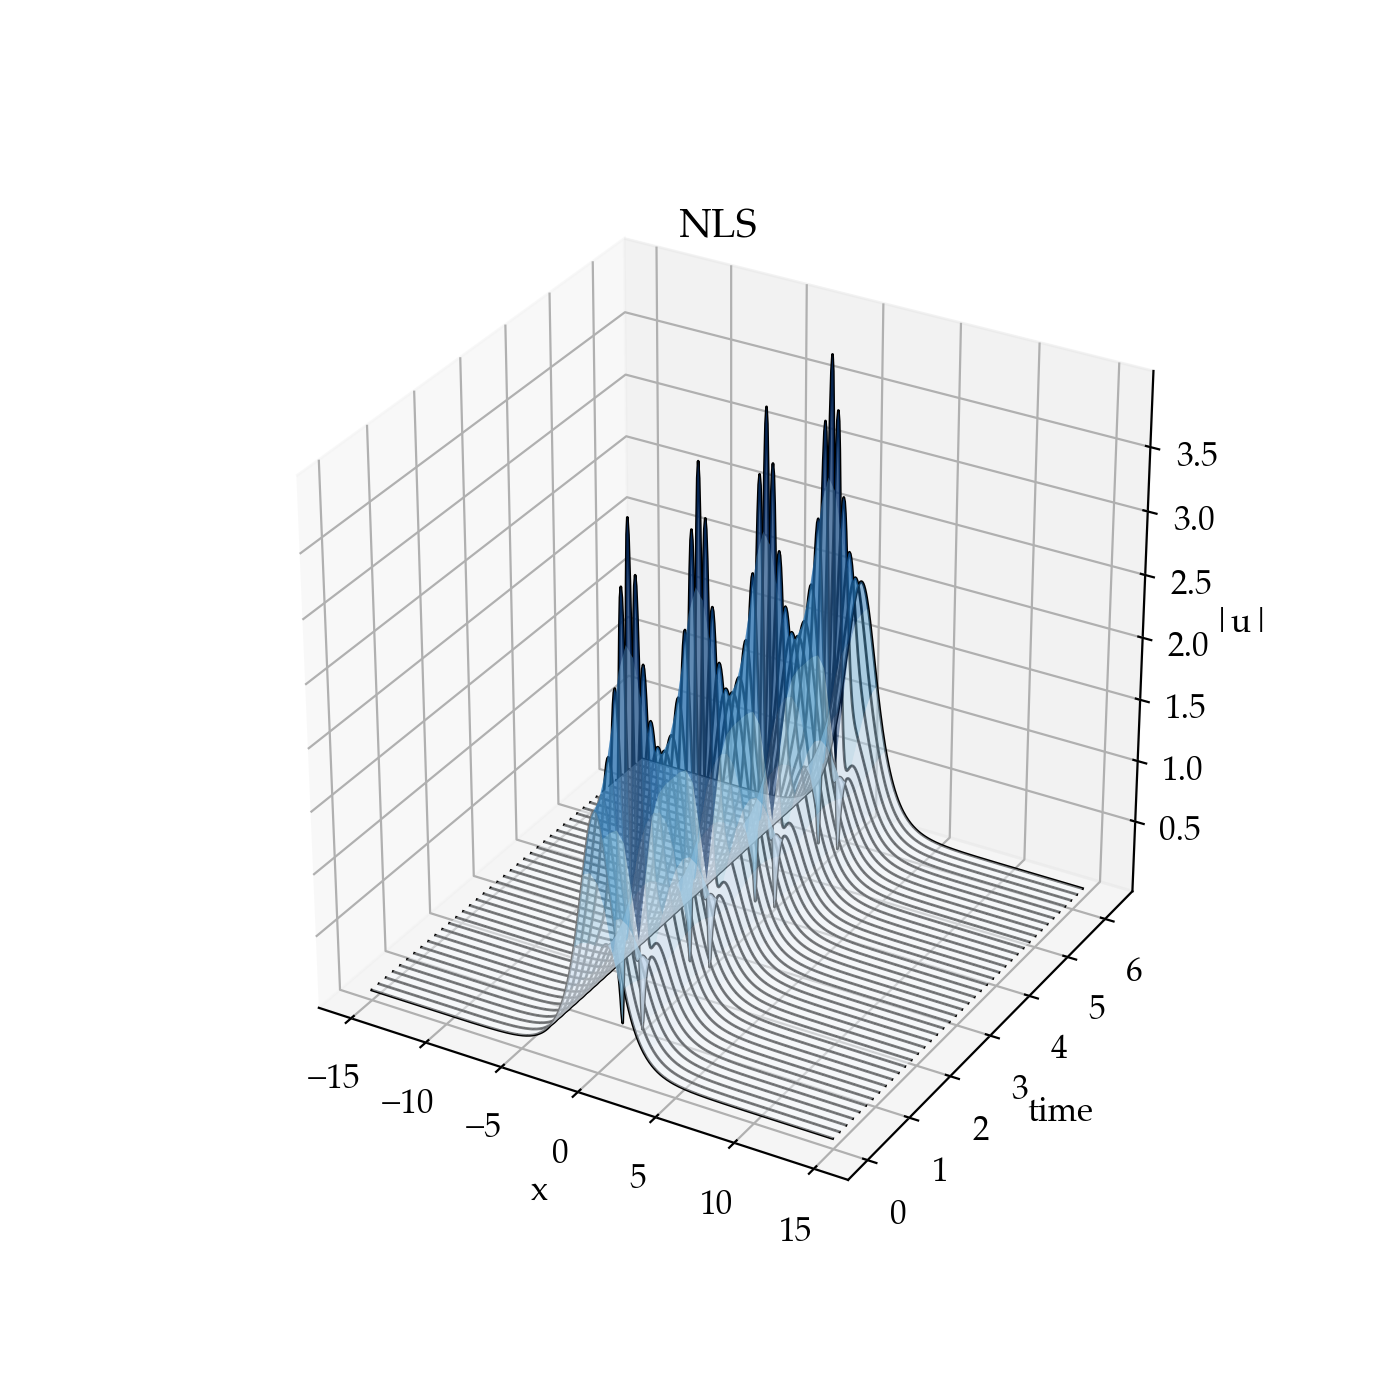

Text(0.5, 0.92, 'NLS')

In [5]:
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, np.abs(u_sol), cmap=cm.Blues, alpha=0.5)
for tt in range(len(t)):
    ax.plot(x, t[tt] * np.ones_like(x), np.abs(u_sol[tt,:]), color='k', linewidth=1)
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('|u|')
plt.title('NLS')

<IPython.core.display.Javascript object>


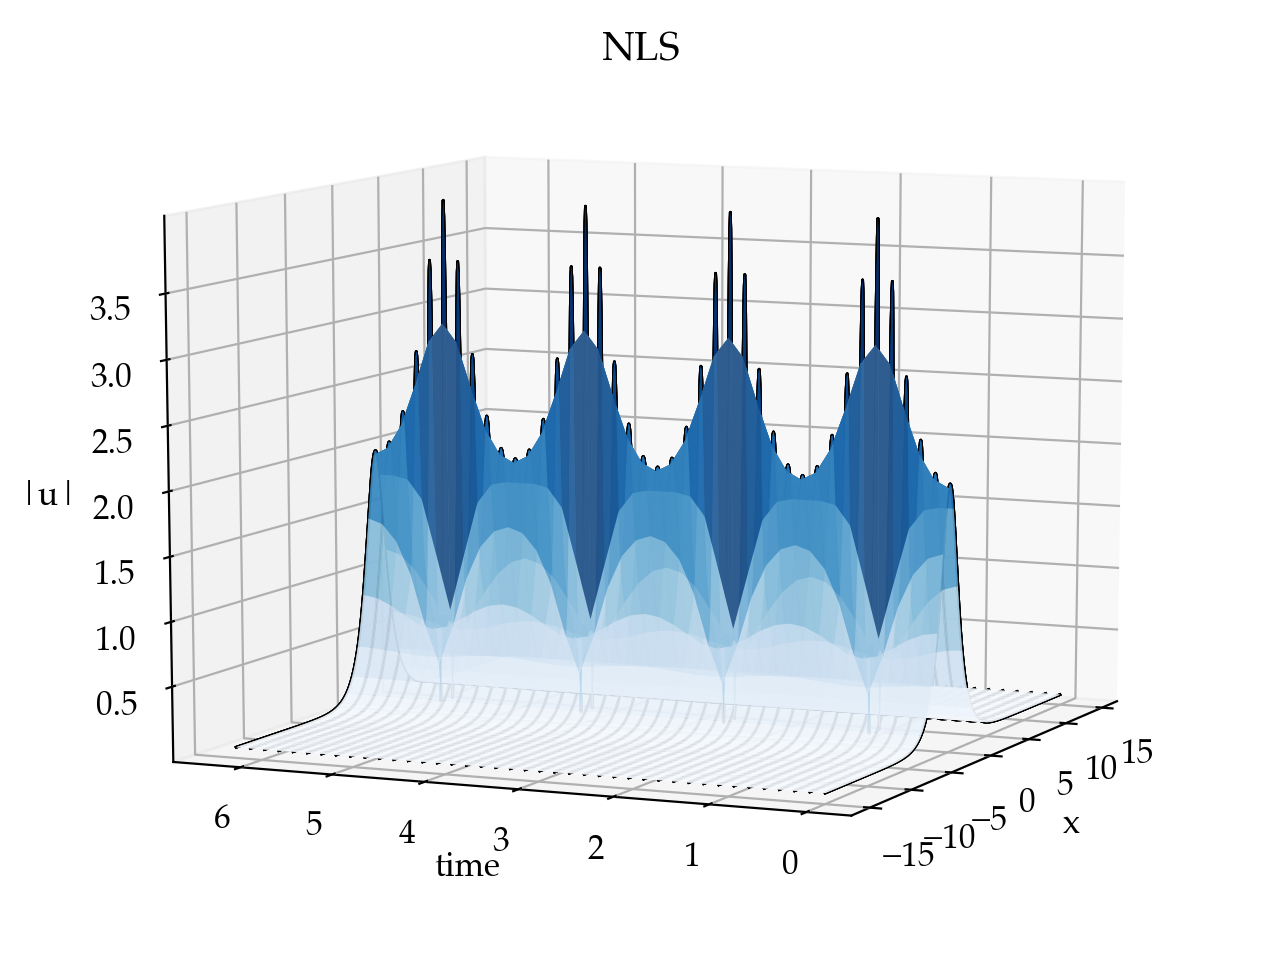

In [6]:
fig = plt.figure()
ax = Axes3D(fig)

def init():
    # Plot the surface.
    ax.plot_surface(X, T, np.abs(u_sol), cmap=cm.Blues, alpha=0.5)
    for tt in range(len(t)):
        ax.plot(x, t[tt] * np.ones_like(x), np.abs(u_sol[tt,:]), color='k', linewidth=1)
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i*4)
    return fig,

ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('|u|')
plt.title('NLS')
# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=50, blit=True)

ani.save('nls.gif',writer='imagemagick',fps=1000/50)

Don't forget out scope, which is not to solve the NLS equation but to build a linear model from just measurements from it. We will now use the POD model computed with SVD. We will transpose the solution on order to stay consistent with the lesson, in which each column is a different snapshot in time.

In [7]:
v = u_sol.T
v1 = v[:, :-1]
v2 = v[:, 1:]

UU, SS, VV = np.linalg.svd(v1, full_matrices=True) # economy SVD
r = 10 # number of modes
U = UU.T[:, 0:r]
S = SS[0:r]
V = VV.T[:, 0:r]
A_tilde = U.T @ v2 @ V @ np.linalg.inv(np.diag(S))
[W, D] = np.linalg.eig(A_tilde)
Phi = v2 @ V @ np.linalg.inv(np.diag(S)) @ W

lmbd = np.diag(D)